d:\JUNK\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\JUNK\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\JUNK\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\JUNK\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less 

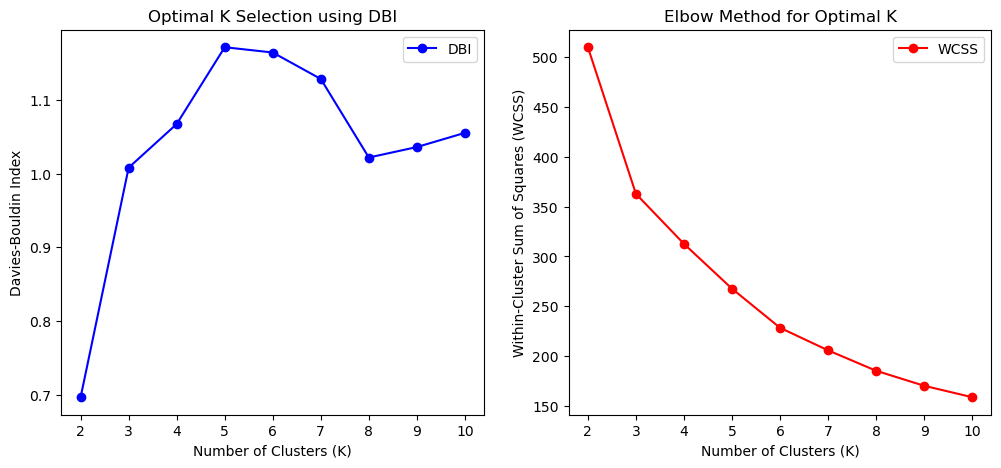

Optimal Number of Clusters: 2


d:\JUNK\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Final Clustering Results:
DB Index: 0.6965
Silhouette Score: 0.5527
Calinski-Harabasz Score: 237.2063


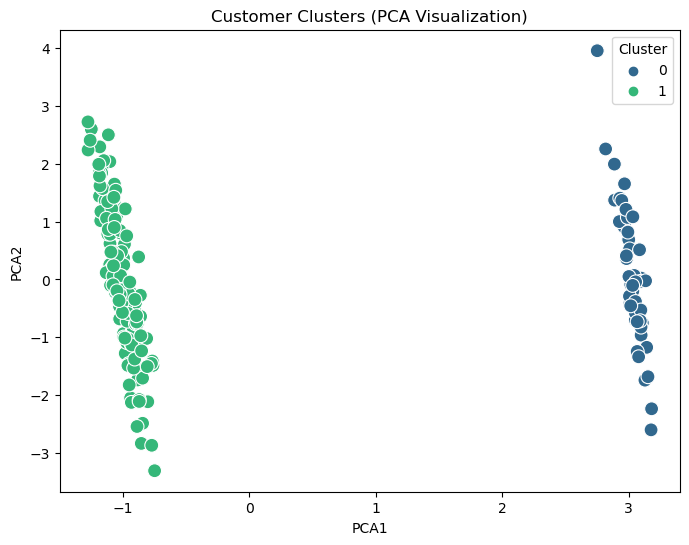

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA

# 1. Load Data
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# 2. Data Preprocessing
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Aggregate Transaction Data per Customer
customer_transactions = transactions.groupby("CustomerID").agg(
    Total_Spend=('TotalValue', 'sum'),
    Avg_Spend=('TotalValue', 'mean'),
    Num_Transactions=('TransactionID', 'count'),
    Total_Quantity=('Quantity', 'sum'),
).reset_index()

# Merge with Customer Profile Data
data = pd.merge(customers, customer_transactions, on="CustomerID", how="left").fillna(0)

# Drop non-numeric columns
data.drop(columns=['CustomerName', 'SignupDate'], inplace=True)

# Encode Region using One-Hot Encoding
data = pd.get_dummies(data, columns=['Region'], drop_first=True)

# 3. Scale the Features
scaler = RobustScaler()
scaled_features = scaler.fit_transform(data.drop(columns=['CustomerID']))

# 4. Determine Optimal Number of Clusters using DBI
dbi_scores = []
silhouette_scores = []
chi_scores = []
wcss = []
k_values = list(range(2, 11))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_features)
    
    dbi_scores.append(davies_bouldin_score(scaled_features, labels))
    silhouette_scores.append(silhouette_score(scaled_features, labels))
    chi_scores.append(calinski_harabasz_score(scaled_features, labels))
    wcss.append(kmeans.inertia_)

# Plot Metrics
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(k_values, dbi_scores, marker='o', linestyle='-', color='b', label='DBI')
ax[0].set_xlabel("Number of Clusters (K)")
ax[0].set_ylabel("Davies-Bouldin Index")
ax[0].set_title("Optimal K Selection using DBI")
ax[0].legend()

ax[1].plot(k_values, wcss, marker='o', linestyle='-', color='r', label='WCSS')
ax[1].set_xlabel("Number of Clusters (K)")
ax[1].set_ylabel("Within-Cluster Sum of Squares (WCSS)")
ax[1].set_title("Elbow Method for Optimal K")
ax[1].legend()

plt.show()

optimal_k = k_values[np.argmin(dbi_scores)]
print(f"Optimal Number of Clusters: {optimal_k}")

# 5. Apply K-Means Clustering with Optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
data["Cluster"] = kmeans.fit_predict(scaled_features)

# 6. Evaluate Final Clustering
dbi_final = davies_bouldin_score(scaled_features, data["Cluster"])
silhouette_final = silhouette_score(scaled_features, data["Cluster"])
chi_final = calinski_harabasz_score(scaled_features, data["Cluster"])

print(f"Final Clustering Results:\n"
      f"DB Index: {dbi_final:.4f}\n"
      f"Silhouette Score: {silhouette_final:.4f}\n"
      f"Calinski-Harabasz Score: {chi_final:.4f}")

# 7. Visualize Clusters using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
data["PCA1"] = pca_features[:, 0]
data["PCA2"] = pca_features[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=data, palette="viridis", s=100)
plt.title("Customer Clusters (PCA Visualization)")
plt.show()

# 8. Save Results
data[['CustomerID', 'Cluster']].to_csv("Customer_Segmentation.csv", index=False)
